# Lab 04: Image Matching and Image Stitching

In this lab, you'll implement and play with the algorithms taught in course 5 and 6. 

- Student Name: NoughtQ
- Student ID: 114514919810
- Date: 2025-10-27

---

## Part I: Image Matching

### Task 1: Find corners with harris detector

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

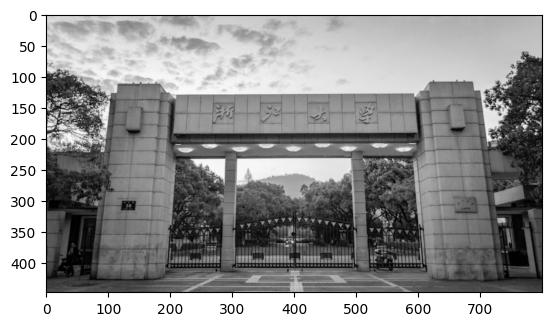

In [2]:
# Let's load an example image
filename = 'building.jpeg'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
fig = plt.imshow(img, cmap='gray')

Step 1. Compute the covariance matrix at each point

$$H=\begin{bmatrix}I_x^2& I_xI_y\\I_xI_y &I_y^2\end{bmatrix}$$

where $I_x=\frac{\partial f}{\partial x}, I_y=\frac{\partial f}{\partial y}$.

In practice, we can further apply a 2D gaussian filter G to smooth H

$$ H'_{i,j,c} = \sum_{m=1}^{W} \sum_{n=1}^{W} G_{m,n} \cdot H_{i+m-\frac{W+1}{2},j+n-\frac{W+1}{2},c} $$

In [3]:
# normalize image to [0,1]
img_float = img.astype(np.float32) / 255.0

# use sobel operator at every location
sobel_x = cv2.Sobel(img_float, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_float, cv2.CV_32F, 0, 1, ksize=3)

# compute H 
H = np.zeros((img.shape[0], img.shape[1], 4))
H[..., 0] = sobel_x * sobel_x
H[..., 1] = sobel_x * sobel_y
H[..., 2] = sobel_x * sobel_y
H[..., 3] = sobel_y * sobel_y

# gaussian weights, what window-size should be used?
window_size = 5
gaussian_kernel_1d = cv2.getGaussianKernel(window_size, 0.5)
gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d.transpose())
H = cv2.filter2D(H, -1, gaussian_kernel_2d)

Step 2. Harris response

Theoretically, we can compute eigenvalues

$H=\begin{bmatrix}a&b\\c&d\end{bmatrix}\quad \lambda_\pm=\frac{1}{2}((a+d)\pm\sqrt{4bc+(a-d)^2})$

and then classify points using eigenvalues of H, like:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/harris_region.jpg" alt="drawing" width="200"/>

However, computing eigenvalues are expensive, so we use the following alternative:

$$f=\frac{\lambda_1 \lambda_2}{\lambda_1+\lambda_2}=\frac{determinant(H)}{trace(H)}$$

where $det(\begin{bmatrix}a&b\\c&d\end{bmatrix})=ad-bc$,   and $trace(\begin{bmatrix}a&b\\c&d\end{bmatrix})=a+d$

In [5]:
# compute harris response
f = (H[..., 0] * H[..., 3] - H[..., 1] * H[..., 2]) / (H[..., 0] + H[..., 3] + 1e-12)

Step 3. Threshold $f$ and visualize

we skip non-maximum suppression operation here. You only need to visualize the thresholded harris response map.

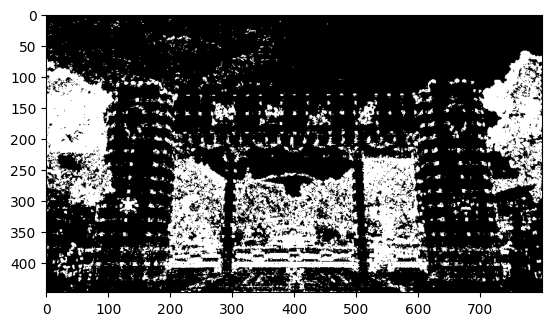

In [13]:
# threshold and visualize the binary response map with plt.imshow(f_binary)
# the threshold is a hyperparameter, try different values
f_binary = (f > 5e-3).astype(np.uint8)
plt.imshow(f_binary, cmap='gray')

Further reading:

[【计算机视觉】2. 特征点检测：Harris, SIFT, SURF, ORB](https://zhuanlan.zhihu.com/p/36382429)

### Task 2: SIFT

To do this task, read [opencv documentation on SIFT](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html) first, and use it for local feature detection and description.

In [17]:
# load an image
img0 = cv2.imread("1.jpeg", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread("2.jpeg", cv2.IMREAD_GRAYSCALE)

In [18]:
# creat sift extractor (detector + descriptor)
SIFT = cv2.SIFT_create()

# get the detector and descriptor
kpts0, descs0 = SIFT.detectAndCompute(img0, None)
kpts1, descs1 = SIFT.detectAndCompute(img1, None)

For SIFT descriptors, people usually match them with ratio-test.

(1) Please list the main advantage of ratio-test in matching SIFT descriptors.

(2) Do you think mutual-nearest-neighbor method can also work?

（1）比例测试（ratio-test）的主要好处是显式对比最近邻和次近邻的距离，只有在两者差距足够大时才保留匹配，能有效剔除模糊/歧义的点，因此误匹配率低、稳定性高。

（2）互为最近邻（mutual NN）也能过滤掉不少伪匹配，但它不区分第一个和第二个邻居的差距；在特征重复或纹理弱时，两个候选距离都很近仍会被接受，鲁棒性通常比比例测试差。不过在约束较强（如严格几何验证）的场景下也可以工作，只是整体质量和抗噪性不如比例测试。

In [20]:
# compute descriptor distance
distance = np.linalg.norm(descs0[:, None, :] - descs1[None, :, :], axis=2)

# ratio test
kpts0_xy = np.array([kp.pt for kp in kpts0], dtype=np.float32)
kpts1_xy = np.array([kp.pt for kp in kpts1], dtype=np.float32)

nearest_idx = np.argsort(distance, axis=1)
best = nearest_idx[:, 0]
second = nearest_idx[:, 1]

best_dist = distance[np.arange(distance.shape[0]), best]
second_dist = distance[np.arange(distance.shape[0]), second]
ratio = best_dist / (second_dist + 1e-12)

keep = ratio < 0.75
mkpts0, mkpts1 = kpts0_xy[keep], kpts1_xy[best[keep]]

And visualize the final matches.

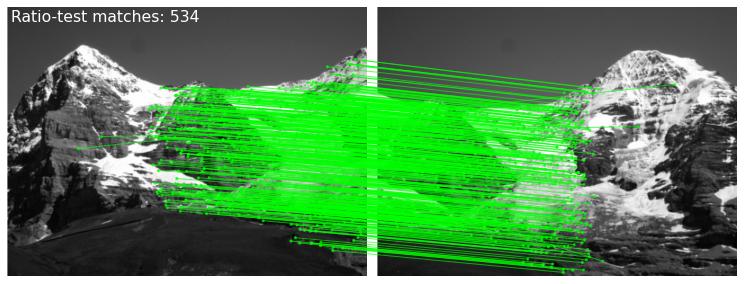

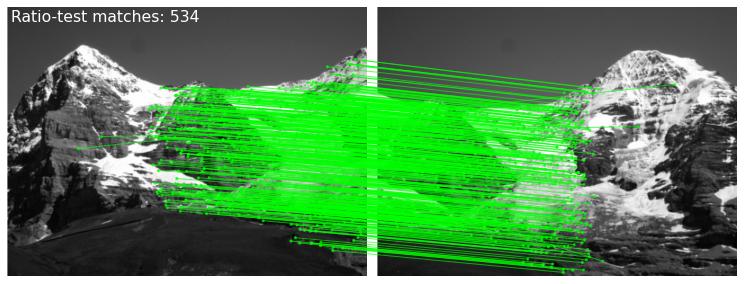

In [34]:
# visualization
# You might need to read the documentation of this function. Or you can write your own drawing function.
from utils import make_matching_figure

fig = make_matching_figure(
    img0, img1,
    mkpts0, mkpts1,
    text=[f'Ratio-test matches: {len(mkpts0)}'],
    # path="sift-result.png"
)
fig

---

## Part II: Image Stitching

One application fo image matching is to stitch multiple images and get one panorama.

### Task 3: Transformation

Considering 2 images as input, you can use SIFT (provided by cv2) to find the transformation between them (implement it on your own).

In [25]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load images
img0_rgb = cv2.imread("1.jpeg", cv2.IMREAD_COLOR)[..., [2, 1, 0]]
img1_rgb = cv2.imread("2.jpeg", cv2.IMREAD_COLOR)[..., [2, 1, 0]]
# 原来读的是 img0 和 img1，但会报错（因为那些是灰度图），所以改成 img0_rgb 和 img1_rgb
img0_gray = cv2.cvtColor(img0_rgb, cv2.COLOR_RGB2GRAY)
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)

In [ ]:
# compute SIFT keypoints and descriptors
# note: on gray image
kpts0_full, descs0 = SIFT.detectAndCompute(img0_gray, None)
kpts1_full, descs1 = SIFT.detectAndCompute(img1_gray, None)

kpts0_xy = np.array([kp.pt for kp in kpts0_full], dtype=np.float32)
kpts1_xy = np.array([kp.pt for kp in kpts1_full], dtype=np.float32)

distance = np.linalg.norm(descs0[:, None, :] - descs1[None, :, :], axis=2)
nearest_idx = np.argsort(distance, axis=1)
best = nearest_idx[:, 0]
second = nearest_idx[:, 1]

best_dist = distance[np.arange(distance.shape[0]), best]
second_dist = distance[np.arange(distance.shape[0]), second]
ratio = best_dist / (second_dist + 1e-12)

keep = ratio < 0.75

# find matches
mkpts0 = kpts0_xy[keep]
mkpts1 = kpts1_xy[best[keep]]

Here, the transformation $H$ is defined as 
$$\begin{bmatrix}x_0\\y_0\\1\end{bmatrix}=\begin{bmatrix}h_{11}&h_{12}&h_{13}\\h_{21}&h_{22}&h_{23}\\0&0&1\end{bmatrix}\begin{bmatrix}x_1\\y_1\\1\end{bmatrix}$$

Please answer:

(1) What type is this transformation?

(2) Please write down the converted equation in the form of $Ah=b$. To solve this equation, what's the minimal number of matches we need? 

1. 2D 仿射变换
2. 展开得到：
    - `x0 = h11 * x1 + h12 * y1 + h13`
    - `y0 = h21 * x1 + h22 * y1 + h23`

    为求解这些方程，至少需要 3 组匹配（6 个方程）才能解，因为有 6 个未知数

In [ ]:
# randomly select K matches (according to your answer)
rng = np.random.default_rng(0)
K = 4
sample_idx = rng.choice(mkpts0.shape[0], K, replace=False)
selected_mkpts0 = mkpts0[sample_idx]
selected_mkpts1 = mkpts0[sample_idx]

# solve the equation
A = []
b = []
for (x, y), (u, v) in zip(selected_mkpts0, selected_mkpts1):
    A.append([x, y, 1, 0, 0, 0])
    A.append([0, 0, 0, x, y, 1])
    b.append(u)
    b.append(v)

A = np.asarray(A, dtype=np.float64)
b = np.asarray(b, dtype=np.float64)

h, *_ = np.linalg.lstsq(A, b, rcond=None)

### Task 4: RANSAC

To use naive ransac algorithm, we need $N$ sample-points(样本点), to solve the model, we need $K$ sample-points as a minimal requirement. Then perform:

1. Randomly sample $K$ sample-points.
2. Fit the model with $K$ sample-points. Denoted as $\hat h$.
3. Compute error of other sample points according to $\hat h$. Count the inliers within some threshold.
4. Repeat $M$ times, the final $h$ is the $\hat h$ with most inliers. 

In [ ]:
# implement your own RANSAC
def ransac_to_estimate_H(samples, K, inlier_thr, M):
    pts0, pts1 = samples
    assert pts0.shape[0] == pts1.shape[0] and pts0.shape[0] >= K

    rng = np.random.default_rng()
    pts0_h = np.hstack([pts0, np.ones((pts0.shape[0], 1))])  # 齐次坐标
    best_H = None
    best_count = 0

    def estimate_H(src, dst):
        A = []
        for (x, y), (u, v) in zip(src, dst):
            A.append([-x, -y, -1, 0, 0, 0, x * u, y * u, u])
            A.append([0, 0, 0, -x, -y, -1, x * v, y * v, v])
        A = np.asarray(A, dtype=np.float64)
        _, _, Vt = np.linalg.svd(A)
        h = Vt[-1] / Vt[-1, -1]
        return h.reshape(3, 3)

    for _ in range(M):
        subset_idx = rng.choice(pts0.shape[0], K, replace=False)
        H_candidate = estimate_H(pts0[subset_idx], pts1[subset_idx])

        proj = (H_candidate @ pts0_h.T).T
        proj = proj[:, :2] / proj[:, 2:3]
        errors = np.linalg.norm(proj - pts1, axis=1)

        inliers = errors < inlier_thr
        count = np.sum(inliers)
        if count > best_count:
            best_count = count
            if count >= K:
                best_H = estimate_H(pts0[inliers], pts1[inliers])

    return best_H


H = ransac_to_estimate_H(
    samples=(mkpts0, mkpts1),
    K=4,
    inlier_thr=3.0,
    M=2000,
)

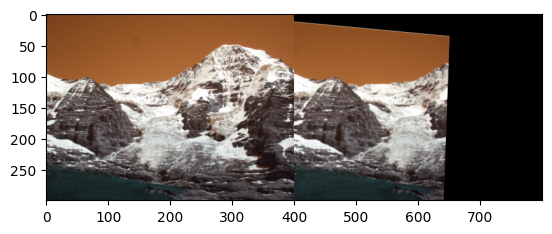

In [ ]:
# use cv2.warpPerspective to put one image on the other
height, width, channels = img1_rgb.shape

# img0 的内容被完全盖住了，需要移出来一部分
T = np.array([
    [1.0, 0.0, width],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
], dtype=np.float64)
H_shifted = T @ H

dsize = (width * 2, height)
panorama = cv2.warpPerspective(img0_rgb, H_shifted, dsize)
panorama[:, :width] = img1_rgb

# use plt to visualize the results
plt.imshow(panorama[..., [2, 1, 0]])

Hot to solve the artifacts in the overlapping region? Name 2 possible methods.

- Feather blending：在重叠区对两幅图的像素按距离进行加权平均，让边界逐渐过渡，从而减弱明显的接缝。
- 多分辨率/多带融合（Laplacian pyramid blending）：先把图像分解到不同频段，再分层混合并重建，可同时兼顾低频亮度过渡和高频细节，效果更自然。